In [1]:
import matplotlib.pyplot as plt
import numpy as np
import keras, random, math, csv, re
from google.colab import drive
import pandas as pd
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, GlobalAveragePooling2D
from keras import models, optimizers
import tensorflow.keras.backend as K
from keras.applications.resnet import ResNet50, preprocess_input

In [2]:
# fashion mnist train 60000, test 1000개 있다
(xf_train, yf_train), (xf_test, yf_test) = fashion_mnist.load_data()
# # transform to rgb - 3차원으로 변환
xf_train = tf.image.grayscale_to_rgb(tf.expand_dims(xf_train, axis=3))
xf_test = tf.image.grayscale_to_rgb(tf.expand_dims(xf_test, axis=3))
# # 이미지 사이즈 재조정
xf_train = tf.image.resize_with_pad(xf_train, 64, 64)
xf_test = tf.image.resize_with_pad(xf_test, 64, 64)
xf_train = preprocess_input(xf_train)
xf_test = preprocess_input(xf_test)



4423680/4422102 [==============================] - 0s 0us/step


In [3]:
#모델만들기 
resnet50_base =tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_shape=(64,64,3))

def resnet50(dp1_rate, dp2_rate, bat_size, lr_rate): 
  x = resnet50_base.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(dp1_rate)(x)
  x = Flatten()(x)
  x = Dense(128, activation = 'relu')(x)
  x =Dropout(dp2_rate)(x) 
  predictions = Dense(10, activation= 'softmax')(x)
  model = Model(inputs = resnet50_base.input, outputs = predictions)

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer = keras.optimizers.Adam(learning_rate=lr_rate),
                metrics = ['accuracy'])

  history = model.fit(xf_train, yf_train,
                      batch_size = bat_size,
                      epochs=10,
                      verbose = 1,
                      validation_data = (xf_test, yf_test))
  new = list(history.history['val_accuracy'])
  return(new)

94773248/94765736 [==============================] - 1s 0us/step


In [4]:
def binary_to_num(population):
    # dropout rate1------------------------------------
    dp_st = [str(i) for i in population[2][:7]]
    dp_string = str("".join(dp_st))
    dp_num = int(dp_string, 2)
    if dp_num > 80: dp_num = 80
    dropout_rate = float(dp_num /100)
    # dropout rate2------------------------------------
    dp2_st = [str(i) for i in population[2][7:14]]
    dp2_string = str("".join(dp2_st))
    dp2_num = int(dp2_string, 2)
    if dp2_num > 80: dp2_num = 80
    dropout2_rate = float(dp2_num /100)
    # batch size---------------------------------------
    batch_st = [str(i) for i in population[2][14:24]]
    batch_string = str("".join(batch_st))
    batch_num = int(batch_string, 2)
    if batch_num > 1000: batch_num = 1000
    # learning rate-------------------------------------
    lr_st = [str(i) for i in population[2][24:]]
    lr_string = str("".join(lr_st))
    lr_num = int(lr_string, 2)
    if lr_num > 100: lr_num = 100
    elif lr_num == 0: lr_num = 1
    lr_rate = float(lr_num / 1000)
    return dropout_rate, dropout2_rate, batch_num, lr_rate

def fitness(population):
    high_accuracy = 0
    dp1_num, dp2_num, batch_num, lr_rate = binary_to_num(population) 
    accuracy = resnet50(dp1_num, dp2_num, batch_num, lr_rate) # 모델 돌려서 accuracy 값 저장
    for i in range(len(accuracy)):
      current_accuracy = round(accuracy[i],4)
      population[1].append(current_accuracy)
      if current_accuracy > high_accuracy: # 가장 높은 accuracy 값 저장
        high_accuracy = current_accuracy
    population= (high_accuracy, population[1], population[2])
    return population

def selection(population, k):
  tournament_pool = random.sample(population, k)
  result = sorted(tournament_pool, key=lambda x:x[0], reverse=True)
  return result[0]

def one_point_crossover(p1, p2):
  if np.array_equal(p1[2], p2[2]):
    return (0, [], p1[2]), (0, [], p2[2])
  else:
    length = len(p1[2])
    cut = random.randint(0, length-1)
    o1 = p1[2][:cut]
    o1.extend(p2[2][cut:])
    o2 = p2[2][:cut]
    o2.extend(p1[2][cut:])
  return (0, [], o1), (0, [], o2)

def two_point_crossover(p1, p2):
  if np.array_equal(p1[2], p2[2]):
    return (0, [], p1[2]), (0, [], p2[2])
  else:
    length = len(p1[2])
    cut1 = random.randint(0, length-1)
    cut2 = random.randint(0, length-1)
    if cut1 < cut2:
      cut1 = cut1
      cut2 = cut2
    elif cut1 > cut2:
      save = cut1
      cut1 = cut2
      cut2 = save
    else:
      pass
    first1, second1, third1 = p1[2][:cut1], p2[2][cut1:cut2], p1[2][cut2:]
    first2, second2, third2 = p2[2][:cut1], p1[2][cut1:cut2], p2[2][cut2:]
    o1 = first1 + second1 + third1
    o2 = first2 + second2 + third2
  return (0, [], o1), (0, [], o2)

def uniform_crossover(p1, p2):
  if np.array_equal(p1[2], p2[2]):
    return (0, [], p1[2]), (0, [], p2[2])
  else:
    length = len(p1[2])
    o1=[]
    o2=[]
    for i in range(length):
      if random.random() < 0.5:
        o1.append(p1[2][i])
        o2.append(p2[2][i])
      else:
        o1.append(p2[2][i])
        o2.append(p1[2][i])
  return (0, [], o1), (0, [], o2)


def bit_inversion_mutation(offspring, rate):
  for i in range(len(offspring[2])):
    if random.random() < rate:
      if offspring[2][i] ==1:
        offspring[2][i]=0
      else:
        offspring[2][i]=1
  return offspring

def scramble_mutation(offspring, rate):
  if random.random() < rate:
    length = len(offspring[2])
    a = random.randint(0, length - 1)
    b = random.randint(0, length - 1)
    if a < b:
      a = a
      b = b
    elif a > b:
      save = a
      a = b
      b = save
    else:
        pass
    first, second, third = offspring[2][:a], offspring[2][a:b], offspring[2][b:]
    new_list = first + random.sample(second, len(second)) + third
    offspring = (offspring[0], offspring[1], new_list)
  return offspring

def inversion_mutation(offspring, rate):
  if random.random() < rate:
    length = len(offspring[2])
    a = random.randint(0, length - 1)
    b = random.randint(0, length - 1)
    if a < b:
      a = a
      b = b
    elif a > b:
      save = a
      a = b
      b = save
    else:
        pass

    first, second, third = offspring[2][:a], offspring[2][a:b], offspring[2][b:]
    new_list = first + second[::-1] + third
    offspring = (offspring[0], offspring[1], new_list)
  return offspring


def ga(pop, gen):
    population = []
    for i in range(pop):
        randomBinaryNumbers = np.random.randint(2, size=31) # 24bit
        accuracy_list =[] # validation accuracy 저장할 리스트
        binary_list = (0, accuracy_list, list(randomBinaryNumbers)) #list로 변환
        fit = fitness(binary_list) # 각 chromosome조합으로 얻은 accuracy
        # print("check", fit)
        population.append(fit)

    for g in range(gen):
      offspring =[]
      while len(offspring) < pop:
        parent1 = selection(population, 3)
        parent2 = selection(population, 3)

        # offspring1, offspring2 = one_point_crossover(parent1, parent2) 
        offspring1, offspring2 = two_point_crossover(parent1, parent2) 
        # offspring1, offspring2 = uniform_crossover(parent1, parent2) 

        offspring1 = inversion_mutation(offspring1, 0.6)
        offspring2 = inversion_mutation(offspring2, 0.6)
       

        offspring1 = fitness(offspring1)
        offspring2 = fitness(offspring2)

        offspring.append(offspring1)
        offspring.append(offspring2)
      pool = population
      pool.extend(offspring)
      pool = sorted(pool, key = lambda x: x[0], reverse=True)
      population = pool[:pop]
    # print("final population ", population)

    final=[]
    for j in range(pop):
      dp_st = [str(i) for i in population[j][2][:7]]
      dp_string = str("".join(dp_st))
      dp_num = int(dp_string, 2)
      if dp_num > 80: dp_num = 80
      dropout_rate = float(dp_num /100)
      # dropout rate2------------------------------------
      dp2_st = [str(i) for i in population[j][2][7:14]]
      dp2_string = str("".join(dp2_st))
      dp2_num = int(dp2_string, 2)
      if dp2_num > 80: dp2_num = 80
      dropout2_rate = float(dp2_num /100)
      # batch size---------------------------------------
      batch_st = [str(i) for i in population[j][2][14:24]]
      batch_string = str("".join(batch_st))
      batch_num = int(batch_string, 2)
      if batch_num > 1000: batch_num = 1000
      # learning rate-------------------------------------
      lr_st = [str(i) for i in population[j][2][24:]]
      lr_string = str("".join(lr_st))
      lr_num = int(lr_string, 2)
      if lr_num > 100: lr_num = 100
      elif lr_num == 0: lr_num = 1
      lr_rate = float(lr_num / 1000)
      savee= (population[j][0], population[j][1], (dropout_rate, dropout2_rate, batch_num, lr_rate))
      final.append(savee)
    # print("final changed",  final)

    drive.mount('/content/drive')
    df = pd.DataFrame(final)
    df.to_csv('/content/drive/My Drive/SEP592_project/resnet_ga_result3.csv', header=None, index=None)


if __name__ == '__main__':
    ga(4, 6)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
[0.9102, 0.9133, 0.9191, 0.9229, 0.918, 0.9136, 0.9203, 0.919, 0.919, 0.9179]


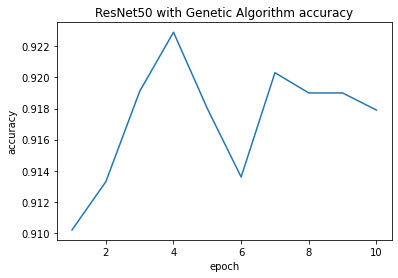

In [5]:
# Genetic Algorithm을 ResNet50에 적용하기
drive.mount('/content/drive')
resnetGA_accuracy=[]
csvfile = list(csv.reader(open('/content/drive/My Drive/SEP592_project/resnet_ga_result2.csv')))
p = '[\d]*[.][\d]+'
num=0

# result 2에서 가장 잘한 accuracy만 뽑아서 그래프 그리기
for row in csvfile:
  # print(row)
  if num == 0:
    if re.search(p, row[1]) is not None:
      for catch in re.finditer(p, row[1]):
        resnetGA_accuracy.append(float(catch[0]))
    num+=1
  else:
    num+=1
print(resnetGA_accuracy)

length2 = np.arange(1,11)
plt.plot(length2, resnetGA_accuracy)
# plt.legend((''), loc='upper right')
plt.title('ResNet50 with Genetic Algorithm accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()